In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
import pandas as pd
from utils import target_loss 
from loader import build_dataloader
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

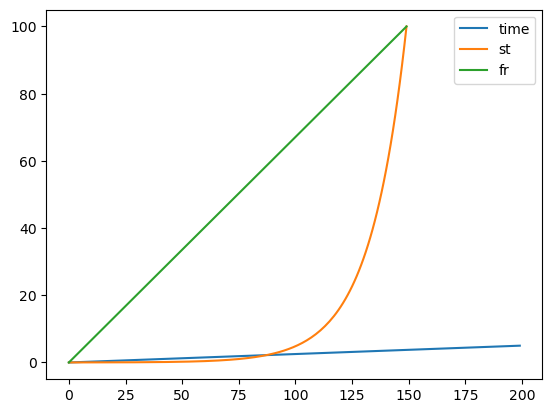

In [2]:
size = 200
size_ = 150
t_max = 5
t = np.linspace(0, t_max, size)
min_fr, max_fr = 0.01, 100
fr = np.linspace(min_fr, max_fr, size_)
start_st, end_st = 0.01, 100
st = np.logspace(np.log10(start_st), np.log10(end_st), size_, endpoint = True)

plt.plot(t, label="time")
plt.plot(st, label="st")
plt.plot(fr, label="fr")
plt.legend()

In [3]:
# the function that we generate the data with
def f(t, st, fr):
    return st**2 * fr * (1 - t/st - np.exp(-t/st))
'''def f(t, st, fr):
    return  st + fr + t'''
data = []
for st_ in st:
    for fr_ in fr:
        example = list(f(t, st_, fr_))
        t_pred = np.random.uniform(0, t_max)
        pred = f(t_pred,st_,fr_)
        example.append(fr_)
        example.append(st_)
        example.append(t_pred)
        example.append(pred)
        data.append(example)
data = np.array(data)
colummns = [str(i) for i in range(size)]
colummns.append("fr")
colummns.append("st")
colummns.append("t_pred")
colummns.append("pred") 
df = pd.DataFrame(data,columns=colummns)
df.to_csv("data.csv")
df.shape

(40000, 204)

In [4]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(size,1,3,100)

# Load and prepare training data
dataloader = build_dataloader(size, batch_size =100)


In [5]:
# Training setup
SAVE_PATH = "trained_models/scinet1.dat"
N_EPOCHS = 150
optimizer = optim.Adam(scinet.parameters(), lr=0.001)
hist_error = []
hist_kl = []
hist_loss = []
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.009, total_iters=N_EPOCHS)
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_kl = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, _, _, question, answer = minibatch['time_series'] / 5, minibatch['fr'] / 5, minibatch['st'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5
        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1)
        # build the output
        outputs = answer

        optimizer.zero_grad()
        # print(inputs[0])
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss_ = target_loss(pred, outputs)
        loss = loss_ + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_kl.append(scinet.kl_loss.data.detach().numpy())
        epoch_loss.append(loss_.data.detach().numpy())
    # break
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    hist_kl.append(np.mean(epoch_kl))

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))
    
    print("Epoch %d -- loss %f, RMS error %f, KL %f" % (epoch+1, hist_loss[-1], hist_error[-1], hist_kl[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1: SGD lr 0.001000 -> 0.000993
Epoch 1 -- loss 75480.835938, RMS error 14.553067, KL 1241.694214
Epoch 2: SGD lr 0.000993 -> 0.000987
Epoch 2 -- loss 73814.367188, RMS error 14.604601, KL 785.579163
Epoch 3: SGD lr 0.000987 -> 0.000980
Epoch 3 -- loss 71244.531250, RMS error 14.641906, KL 433.047852
Epoch 4: SGD lr 0.000980 -> 0.000974
Epoch 4 -- loss 67076.101562, RMS error 14.282802, KL 587.199036
Epoch 5: SGD lr 0.000974 -> 0.000967
Epoch 5 -- loss 50522.863281, RMS error 12.470662, KL 1809.717041
Epoch 6: SGD lr 0.000967 -> 0.000960
Epoch 6 -- loss 19350.957031, RMS error 7.898008, KL 1014.380005
Epoch 7: SGD lr 0.000960 -> 0.000954
Epoch 7 -- loss 8182.104492, RMS error 5.100238, KL 652.165405
Epoch 8: SGD lr 0.000954 -> 0.000947
Epoch 8 -- loss 4572.907715, RMS error 3.549310, KL 458.224304
Epoch 9: SGD lr 0.000947 -> 0.000941
Epoch 9 -- loss 2706.835449, RMS error 2.664870, KL 380.438202
Epoch 10: SGD lr 0.000941 -> 0.000934
Epoch 10 -- loss 1767.798584, RMS error 2.064713

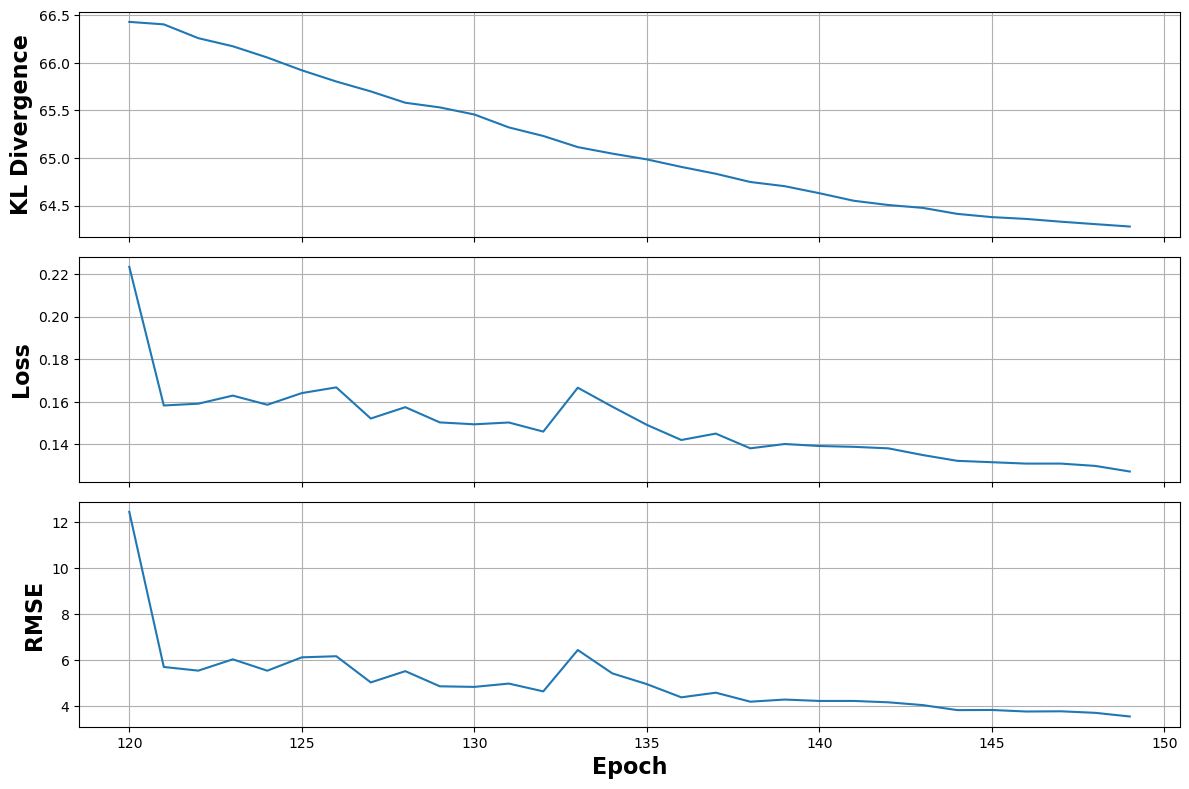

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
end = 120
epochs = range(end,N_EPOCHS)
# Plot the first subplot
axs[0].plot(epochs,hist_kl[end:])
axs[0].set_ylabel("KL Divergence", fontsize=16, fontweight='bold')
axs[0].grid(True)

# Plot the second subplot
axs[1].plot(epochs,hist_error[end:])
axs[1].set_ylabel("Loss", fontsize=16, fontweight='bold')
axs[1].grid(True)

# Plot the third subplot
axs[2].plot(epochs,hist_loss[end:])
axs[2].set_xlabel("Epoch", fontsize=16, fontweight='bold')
axs[2].set_ylabel("RMSE", fontsize=16, fontweight='bold')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot as 'loss.pdf'
plt.savefig('plot/loss.pdf')


# Show the plot (optional)
plt.show()

